# Feature Engineering with PySpark

## Exploratory data analysis

In [1]:
# Import libraries
import sys
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('p4-feature-engineering-with-pyspark').getOrCreate()
print(f'Spark version: {spark.version}')
print(f'system version: {sys.version_info}')

23/08/07 23:58:17 WARN Utils: Your hostname, Dino-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using fd01:db8:1111:0:0:0:0:3 instead (on interface lo0)
23/08/07 23:58:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/07 23:58:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 3.4.1
system version: sys.version_info(major=3, minor=9, micro=16, releaselevel='final', serial=0)


In [2]:
# Load data
data_file_path = 'datasets/2017_StPaul_MN_Real_Estate.csv'
df = spark.read.csv(data_file_path, header=True, inferSchema=True)
df.show(5)

23/08/07 23:58:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+--------------+---------+---------------+-----------------+------------+--------------+----------+---------+-----------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+------------------+--------------------+-----+------------------+--------------------+----------------+--------------+---------+------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------+

In [3]:
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

Number of rows: 5000
Number of columns: 74


### Defining a problem

#### What are we predicting?

In [4]:
# Select our dependent variable
Y_df = df.select(['SALESCLOSEPRICE'])
# Display summary statistics
Y_df.describe().show()

+-------+------------------+
|summary|   SALESCLOSEPRICE|
+-------+------------------+
|  count|              5000|
|   mean|       262804.4668|
| stddev|140559.82591998563|
|    min|             48000|
|    max|           1700000|
+-------+------------------+



#### Verifying Data load

In [5]:
def check_load(df, num_records, num_columns):
    # Takes a dataframe and compares record and column counts to input
    # Message to return if the critera below aren't met
    message = 'Validation Failed'
    # Check number of records
    if num_records == df.count():
        # Check number of columns
        if num_columns == len(df.columns):
            # Success message
            message = 'Validation Passed'
    return message

# Print the data validation message
print(check_load(df, 5000, 74))

Validation Passed


#### Verifying DataTypes

In [6]:
validation_dict = {'ASSESSMENTPENDING': 'string',
                    'AssessedValuation': 'double',
                    'AssociationFee': 'bigint',
                    'AssumableMortgage': 'string',
                    'SQFTBELOWGROUND': 'bigint'}

In [7]:
# create list of actual dtypes to check
actual_dtypes_list = df.dtypes
print(actual_dtypes_list)

# Iterate through the list of actual dtypes tuples
for attribute_tuple in actual_dtypes_list:
  
  # Check if column name is dictionary of expected dtypes
  col_name = attribute_tuple[0]
  if col_name in validation_dict:

    # Compare attribute types
    col_type = attribute_tuple[1]
    if col_type == validation_dict[col_name]:
      print(col_name + ' has expected dtype.')

[('No.', 'int'), ('MLSID', 'string'), ('StreetNumberNumeric', 'int'), ('streetaddress', 'string'), ('STREETNAME', 'string'), ('PostalCode', 'int'), ('StateOrProvince', 'string'), ('City', 'string'), ('SalesClosePrice', 'int'), ('LISTDATE', 'string'), ('LISTPRICE', 'int'), ('LISTTYPE', 'string'), ('OriginalListPrice', 'int'), ('PricePerTSFT', 'double'), ('FOUNDATIONSIZE', 'int'), ('FENCE', 'string'), ('MapLetter', 'string'), ('LotSizeDimensions', 'string'), ('SchoolDistrictNumber', 'string'), ('DAYSONMARKET', 'int'), ('offmarketdate', 'string'), ('Fireplaces', 'int'), ('RoomArea4', 'string'), ('roomtype', 'string'), ('ROOF', 'string'), ('RoomFloor4', 'string'), ('PotentialShortSale', 'string'), ('PoolDescription', 'string'), ('PDOM', 'int'), ('GarageDescription', 'string'), ('SQFTABOVEGROUND', 'int'), ('Taxes', 'int'), ('RoomFloor1', 'string'), ('RoomArea1', 'string'), ('TAXWITHASSESSMENTS', 'double'), ('TAXYEAR', 'int'), ('LivingArea', 'int'), ('UNITNUMBER', 'string'), ('YEARBUILT', 'i

### Visually Inspecting Data / EDA

#### Using `corr()`

In [8]:
columns = ['FOUNDATIONSIZE',
            'DAYSONMARKET',
            'FIREPLACES',
            'PDOM',
            'SQFTABOVEGROUND',
            'TAXES',
            'TAXWITHASSESSMENTS',
            'TAXYEAR',
            'LIVINGAREA',
            'YEARBUILT',
            'ACRES',
            'BACKONMARKETDATE',
            'BATHSFULL',
            'BATHSHALF',
            'BATHQUARTER',
            'BATHSTHREEQUARTER',
            'BATHSTOTAL',
            'BEDROOMS',
            'SQFTBELOWGROUND',
            'ASSOCIATIONFEE',
            'ASSESSEDVALUATION']

In [9]:
# print out data types of each column
for col in columns:
    print(col, df.select(col).dtypes)

FOUNDATIONSIZE [('FOUNDATIONSIZE', 'int')]
DAYSONMARKET [('DAYSONMARKET', 'int')]
FIREPLACES [('FIREPLACES', 'int')]
PDOM [('PDOM', 'int')]
SQFTABOVEGROUND [('SQFTABOVEGROUND', 'int')]
TAXES [('TAXES', 'int')]
TAXWITHASSESSMENTS [('TAXWITHASSESSMENTS', 'double')]
TAXYEAR [('TAXYEAR', 'int')]
LIVINGAREA [('LIVINGAREA', 'int')]
YEARBUILT [('YEARBUILT', 'int')]
ACRES [('ACRES', 'double')]
BACKONMARKETDATE [('BACKONMARKETDATE', 'string')]
BATHSFULL [('BATHSFULL', 'int')]
BATHSHALF [('BATHSHALF', 'int')]
BATHQUARTER [('BATHQUARTER', 'int')]
BATHSTHREEQUARTER [('BATHSTHREEQUARTER', 'int')]
BATHSTOTAL [('BATHSTOTAL', 'int')]
BEDROOMS [('BEDROOMS', 'int')]
SQFTBELOWGROUND [('SQFTBELOWGROUND', 'int')]
ASSOCIATIONFEE [('ASSOCIATIONFEE', 'int')]
ASSESSEDVALUATION [('ASSESSEDVALUATION', 'double')]


In [10]:
df.select('BACKONMARKETDATE').show(10)

+----------------+
|BACKONMARKETDATE|
+----------------+
|            null|
|            null|
|            null|
|            null|
|            null|
|            null|
|            null|
|            null|
|            null|
|            null|
+----------------+
only showing top 10 rows



In [11]:
from pyspark.sql.types import DoubleType
# catch BACKONMARKETDATE column to double type
df = df.withColumn("BACKONMARKETDATE", df["BACKONMARKETDATE"].cast(DoubleType()))

In [12]:
# Name and value of col with max corr
corr_max = 0
corr_max_col = columns[0]

# Loop to check all columns contained in list
for col in columns:
    # Check the correlation of a pair of columns
    corr_val = df.corr(col, 'SALESCLOSEPRICE')
    # Logic to compare corr_max with current corr_val
    if corr_val > corr_max:
        # Update the column name and corr value
        corr_max = corr_val
        corr_max_col = col

print(corr_max_col)

LIVINGAREA


#### Using Visualizations: distplot

/var/folders/66/6rbnzyf91v9d5v8nb46hmn0h0000gn/T/ipykernel_36650/3639557235.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pandas_df)


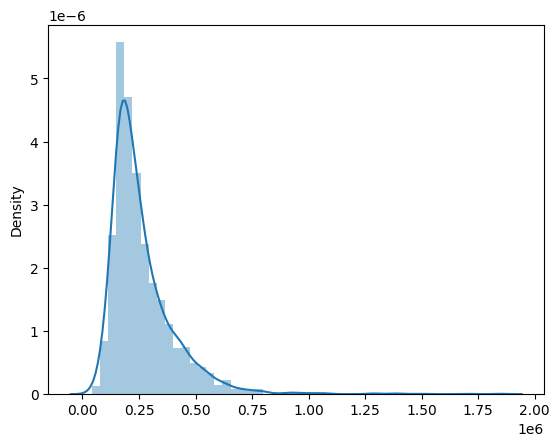

[Row(skewness(LISTPRICE)=2.790448093916559)]


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a single column and sample and convert to pandas
sample_df = df.select(['LISTPRICE']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()

# Import skewness function
from pyspark.sql.functions import skewness

# Compute and print skewness of LISTPRICE
print(df.agg({'LISTPRICE': 'skewness'}).collect())

#### Using Visualizations: lmplot

/Users/ngohongthai/miniconda3/envs/data-engineering/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


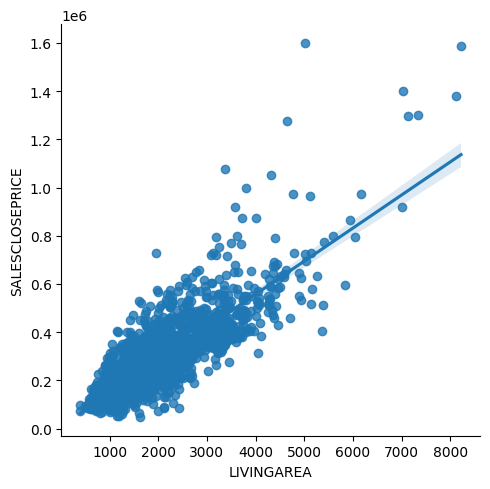

In [14]:
# Select a the relevant columns and sample
sample_df = df.select(['SALESCLOSEPRICE', 'LIVINGAREA']).sample(False, 0.5, 42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

# Linear model plot of pandas_df
sns.lmplot(x='LIVINGAREA', y='SALESCLOSEPRICE', data=pandas_df)
plt.show()

## Wrangling with Spark Functions

### Dropping data

#### Droping a list of columns

In [15]:
# Show top 30 records
df.show(30)

# List of columns to remove from dataset
cols_to_drop = ['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']

# Drop columns in list
df = df.drop(*cols_to_drop)

+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+---------------+---------+---------------+-----------------+------------+--------------+----------------+---------+--------------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+--------------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+--------------------+--------------------+-----+------------------+--------------------+----------------+--------------------+---------+--------------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--

#### Using text filters to remove records

In [16]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
df.select(['ASSUMABLEMORTGAGE']).distinct().show()

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+



In [17]:
# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']


In [18]:
text_filter = ~df['ASSUMABLEMORTGAGE'].isin(yes_values) | df['ASSUMABLEMORTGAGE'].isNull()
df = df.filter(text_filter)
df

DataFrame[No.: int, MLSID: string, streetaddress: string, STREETNAME: string, PostalCode: int, StateOrProvince: string, City: string, SalesClosePrice: int, LISTDATE: string, LISTPRICE: int, LISTTYPE: string, OriginalListPrice: int, PricePerTSFT: double, FOUNDATIONSIZE: int, FENCE: string, MapLetter: string, SchoolDistrictNumber: string, DAYSONMARKET: int, offmarketdate: string, Fireplaces: int, RoomArea4: string, roomtype: string, ROOF: string, RoomFloor4: string, PotentialShortSale: string, PoolDescription: string, PDOM: int, GarageDescription: string, SQFTABOVEGROUND: int, Taxes: int, RoomFloor1: string, RoomArea1: string, TAXWITHASSESSMENTS: double, TAXYEAR: int, LivingArea: int, UNITNUMBER: string, YEARBUILT: int, ZONING: string, STYLE: string, ACRES: double, CoolingDescription: string, APPLIANCES: string, BACKONMARKETDATE: double, ROOMFAMILYCHAR: string, RoomArea3: string, EXTERIOR: string, RoomFloor3: string, RoomFloor2: string, RoomArea2: string, DiningRoomDescription: string, B

In [19]:
df.count()

4976

In [20]:
df.select('ASSUMABLEMORTGAGE').distinct().show()

+------------------+
| ASSUMABLEMORTGAGE|
+------------------+
|Information Coming|
|              null|
|     Not Assumable|
+------------------+



#### Filtering numeric fields conditionally

In [21]:
df = df.drop(*['No.'])

In [22]:
from pyspark.sql.functions import mean, stddev

# Calculate values used for outlier filtering
mean_val = df.agg({'SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = df.agg({'SalesClosePrice': 'stddev'}).collect()[0][0]

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df = df.filter((df['SalesClosePrice'] < hi_bound) & (df['SalesClosePrice'] > low_bound))

### Adjusying Data

#### Custom Percentage scaling

In [23]:
# Define max and min values and collect them
max_days = df.agg({"DAYSONMARKET": "max"}).collect()[0][0]
min_days = df.agg({"DAYSONMARKET": "min"}).collect()[0][0]

# Create a new column based off the scaled data
df = df.withColumn('percentagescaleddays', 
                  df['DAYSONMARKET'] * ((df['DAYSONMARKET'] - min_days) / (max_days - min_days)) * 100)

# Calc max and min for new column
print(df.agg({"percentagescaleddays": "max"}).collect()[0][0])
print(df.agg({"percentagescaleddays": "min"}).collect()[0][0])

22500.0
0.0


#### Scaling your scalers

In [24]:
cols_to_scale = ['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES']

In [25]:
def min_max_scaler(df, cols_to_scale):
  # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
  for col in cols_to_scale:
    # Define min and max values and collect them
    max_days = df.agg({col: 'max'}).collect()[0][0]
    min_days = df.agg({col: 'min'}).collect()[0][0]
    new_column_name = 'scaled_' + col
    # Create a new column based off the scaled data
    df = df.withColumn(new_column_name, 
                      (df[col] - min_days) / (max_days - min_days))
  return df
  
df = min_max_scaler(df, cols_to_scale)
# Show that our data is now between 0 and 1
df[['DAYSONMARKET', 'scaled_DAYSONMARKET']].show()

+------------+--------------------+
|DAYSONMARKET| scaled_DAYSONMARKET|
+------------+--------------------+
|          10|0.044444444444444446|
|           4|0.017777777777777778|
|          28| 0.12444444444444444|
|          19| 0.08444444444444445|
|          21| 0.09333333333333334|
|          17| 0.07555555555555556|
|          32| 0.14222222222222222|
|           5|0.022222222222222223|
|          23| 0.10222222222222223|
|          73|  0.3244444444444444|
|          80| 0.35555555555555557|
|          79|  0.3511111111111111|
|          12| 0.05333333333333334|
|           1|0.004444444444444...|
|          18|                0.08|
|           2|0.008888888888888889|
|          12| 0.05333333333333334|
|          45|                 0.2|
|          31| 0.13777777777777778|
|          16| 0.07111111111111111|
+------------+--------------------+
only showing top 20 rows



#### Correcting Right Skew Data

In [26]:
from pyspark.sql.functions import log

# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / log(df['Reflect_YearBuilt']))

[Row(skewness(YEARBUILT)=-0.2530704729706863)]


In [27]:
print(df.agg({'adj_yearbuilt': 'skewness'}).collect())

[Row(skewness(adj_yearbuilt)=4.237294447853162)]


### Working with Missing Data

#### Visualizing missing data

In [28]:
columns = \
['APPLIANCES',
 'BACKONMARKETDATE',
 'ROOMFAMILYCHAR',
 'BASEMENT',
 'DININGROOMDESCRIPTION']

columns

['APPLIANCES',
 'BACKONMARKETDATE',
 'ROOMFAMILYCHAR',
 'BASEMENT',
 'DININGROOMDESCRIPTION']

In [29]:
# Sample the dataframe and convert to Pandas
sample_df = df.select(*columns).sample(False, 0.1, 42 )
pandas_df = sample_df.toPandas()

pandas_df.head()

,APPLIANCES,BACKONMARKETDATE,ROOMFAMILYCHAR,BASEMENT,DININGROOMDESCRIPTION
0,"Range, Microwave, Dishwasher, Refrigerator, Fr...",NaN,"Main Level, Family Room, Loft",None,"Informal Dining Room, Eat In Kitchen"
1,"Range, Microwave, Dishwasher, Refrigerator, Fr...",NaN,Loft,None,"Informal Dining Room, Kitchen/Dining Room"
2,"Range, Microwave, Dishwasher, Refrigerator, Fr...",NaN,Loft,None,"Informal Dining Room, Kitchen/Dining Room"
3,"Range, Microwave, Dishwasher, Refrigerator, Wa...",NaN,"Main Level, Lower Level, 2 Story/High/Vaulted ...","Full, Finished (Livable), Drain Tiled, Sump Pu...","Separate/Formal Dining Room, Eat In Kitchen"
4,"Microwave, Dishwasher, Refrigerator, Air-To-Ai...",NaN,Great Room,"Walkout, Drain Tiled","Informal Dining Room, Kitchen/Dining Room"


In [30]:
# Convert all values to T/F (True/False)
tf_df = pandas_df.isnull()
tf_df.head()

,APPLIANCES,BACKONMARKETDATE,ROOMFAMILYCHAR,BASEMENT,DININGROOMDESCRIPTION
0,False,True,False,False,False
1,False,True,False,False,False
2,False,True,False,False,False
3,False,True,False,False,False
4,False,True,False,False,False


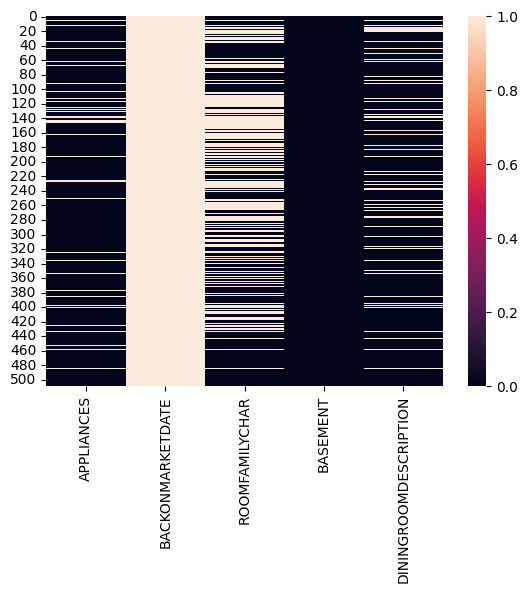

In [31]:
# Plot it
sns.heatmap(tf_df)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

#### Imputing Missing Data

In [32]:
# Count missing rows
missing = df.where(df['PDOM'].isNull()).count()
missing

0

In [33]:
col_mean = df.agg({'PDOM': 'mean'}).collect()[0][0]
col_mean

20.607923218296918

In [34]:
df.fillna(col_mean, subset=['PDOM'])

DataFrame[MLSID: string, streetaddress: string, STREETNAME: string, PostalCode: int, StateOrProvince: string, City: string, SalesClosePrice: int, LISTDATE: string, LISTPRICE: int, LISTTYPE: string, OriginalListPrice: int, PricePerTSFT: double, FOUNDATIONSIZE: int, FENCE: string, MapLetter: string, SchoolDistrictNumber: string, DAYSONMARKET: int, offmarketdate: string, Fireplaces: int, RoomArea4: string, roomtype: string, ROOF: string, RoomFloor4: string, PotentialShortSale: string, PoolDescription: string, PDOM: int, GarageDescription: string, SQFTABOVEGROUND: int, Taxes: int, RoomFloor1: string, RoomArea1: string, TAXWITHASSESSMENTS: double, TAXYEAR: int, LivingArea: int, UNITNUMBER: string, YEARBUILT: int, ZONING: string, STYLE: string, ACRES: double, CoolingDescription: string, APPLIANCES: string, BACKONMARKETDATE: double, ROOMFAMILYCHAR: string, RoomArea3: string, EXTERIOR: string, RoomFloor3: string, RoomFloor2: string, RoomArea2: string, DiningRoomDescription: string, BASEMENT: s

#### Calculate Missing Percents

In [35]:
def column_dropper(df, threshold):
  # Takes a dataframe and threshold for missing values. Returns a dataframe.
  total_records = df.count()
  for col in df.columns:
    # Calculate the percentage of missing values
    missing = df.where(df[col].isNull()).count()
    missing_percent = missing / total_records
    # Drop column if percent of missing is more than threshold
    if missing_percent > threshold:
      df = df.drop(col)
  return df

# Drop columns that are more than 60% missing
df = column_dropper(df, .6)

### Getting More Data

#### A Dangerous Join

In [ ]:
# Cast data types
walk_df = walk_df.withColumn('longitude', walk_df['longitude'].cast('double'))
walk_df = walk_df.withColumn('longitude', walk_df['longitude'].cast('double'))

# Round precision
df = df.withColumn('longitude', round('longitude', 5))
df = df.withColumn('latitude', round('latitude', 5))

# Create join condition
condition = [walk_df['longitude'] == df['longitude'], walk_df['latitude'] == df['latitude']]

# Join the dataframes together
join_df = df.join(walk_df, on=condition, how='left')
# Count non-null records from new field
print(join_df.where(~join_df['walkscore'].isNull()).count())

#### Spark SQL Join

In [ ]:
# Register dataframes as tables
df.createOrReplaceTempView('df')
walk_df.createOrReplaceTempView('walk_df')

# SQL to join dataframes
join_sql = 	"""
			SELECT 
				*
			FROM df
			LEFT JOIN walk_df
			ON df.longitude = walk_df.longitude
			AND df.latitude = walk_df.latitude
			"""
# Perform sql join
joined_df = spark.sql(join_sql)

#### Checking for Bad Joins

In [ ]:
# Join on mismatched keys precision 
wrong_prec_cond = [df_orig['longitude'] == walk_df['longitude'], df_orig['latitude'] == walk_df['latitude']]
wrong_prec_df = df_orig.join(walk_df, on=wrong_prec_cond, how='left')

# Compare bad join to the correct one
print(wrong_prec_df.where(wrong_prec_df['walkscore'].isNull()).count())
print(correct_join_df.where(correct_join_df['walkscore'].isNull()).count())

# Create a join on too few keys
few_keys_cond = [df['longitude'] == walk_df['longitude']]
few_keys_df = df.join(walk_df, on=few_keys_cond, how='left')

## Feature Engineering with PySpark

### Feature Generation

#### Differences

In [37]:
# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])

# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SALESCLOSEPRICE: " + str(df.corr('ACRES', 'SALESCLOSEPRICE')))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(df.corr('FOUNDATIONSIZE', 'SALESCLOSEPRICE')))
# Corr of YARD_SIZE vs SALESCLOSEPRICE
print("Corr of YARD_SIZE vs SALESCLOSEPRICE: " + str(df.corr('YARD_SIZE', 'SALESCLOSEPRICE')))

Corr of ACRES vs SALESCLOSEPRICE: 0.21498966412798348
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.5668477240931833
Corr of YARD_SIZE vs SALESCLOSEPRICE: 0.20337519509231158


#### Ratios

In [38]:
# ASSESSED_TO_LIST
df = df.withColumn('ASSESSED_TO_LIST', df['ASSESSEDVALUATION']/df['LISTPRICE'])
df[['ASSESSEDVALUATION', 'LISTPRICE', 'ASSESSED_TO_LIST']].show(5)
# TAX_TO_LIST
df = df.withColumn('TAX_TO_LIST', df['TAXES']/df['LISTPRICE'])
df[['TAX_TO_LIST', 'TAXES', 'LISTPRICE']].show(5)
# BED_TO_BATHS
df = df.withColumn('BED_TO_BATHS', df['BEDROOMS']/ df['BATHSTOTAL'])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].show(5)

+-----------------+---------+----------------+
|ASSESSEDVALUATION|LISTPRICE|ASSESSED_TO_LIST|
+-----------------+---------+----------------+
|              0.0|   139900|             0.0|
|              0.0|   210000|             0.0|
|              0.0|   225000|             0.0|
|              0.0|   230000|             0.0|
|              0.0|   239900|             0.0|
+-----------------+---------+----------------+
only showing top 5 rows

+--------------------+-----+---------+
|         TAX_TO_LIST|TAXES|LISTPRICE|
+--------------------+-----+---------+
|0.013280914939242315| 1858|   139900|
| 0.00780952380952381| 1640|   210000|
|0.010622222222222222| 2390|   225000|
|0.009330434782608695| 2146|   230000|
|0.008378491037932471| 2010|   239900|
+--------------------+-----+---------+
only showing top 5 rows

+------------------+--------+----------+
|      BED_TO_BATHS|BEDROOMS|BATHSTOTAL|
+------------------+--------+----------+
|               1.5|       3|         2|
|1.333333333

#### Deeper Features

In [41]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

# Create new feature by adding two features together
df = df.withColumn('Total_SQFT', df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND'])

# Create additional new feature using previously created feature
df = df.withColumn('BATHS_PER_1000SQFT', df['BATHSTOTAL'] / (df['Total_SQFT'] / 1000))
df[['BATHS_PER_1000SQFT']].describe().show()

# Sample and create pandas dataframe
pandas_df = df.sample(False, 0.5, 0).toPandas()

# Linear model plots
sns.jointplot(x='Total_SQFT', y='SALESCLOSEPRICE', data=pandas_df, kind="reg", stat_func=r2)
plt.show()
sns.jointplot(x='BATHS_PER_1000SQFT', y='SALESCLOSEPRICE', data=pandas_df, kind="reg", stat_func=r2)
plt.show()

+-------+-------------------+
|summary| BATHS_PER_1000SQFT|
+-------+-------------------+
|  count|               4897|
|   mean| 1.4383520975353432|
| stddev| 14.276603528584948|
|    min|0.39123630672926446|
|    max|             1000.0|
+-------+-------------------+



### Time Features

#### Time Components

In [ ]:
# Import needed functions
from pyspark.sql.functions import to_date, dayofweek

# Convert to date type
df = df.withColumn('LISTDATE', to_date('LISTDATE'))

# Get the day of the week
df = df.withColumn('List_Day_of_Week', dayofweek('LISTDATE'))

# Sample and convert to pandas dataframe
sample_df = df.sample(False, .5, 42).toPandas()

# Plot count plot of of day of week
sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

### Joining On Time Components